# **Histogram**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Soft Computing Resources/AlgX3_64x64_merged_tensors_with_labels.zip'
extract_path = '/content/'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/AlgX3_64x64_merged_tensors_with_labels.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [ ]:
!pip install transformers torch torchvision

In [ ]:
!pip install optuna

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ViT's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset setup
data_dir = '/content/AlgX3_64x64_merged_tensors_with_labels'  # Path to your data
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Splitting the dataset into 80% training, 10% validation, 10% test
train_size = int(0.8 * len(dataset))
val_test_size = len(dataset) - train_size
val_size = val_test_size // 2
test_size = val_test_size - val_size  # Ensure total matches dataset size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
model.to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Early stopping parameters
patience = 5  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
patience_counter = 0

# Training loop with validation and early stopping
for epoch in range(10):  # Run for 10 epochs
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate validation accuracy
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/10, Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model if it has improved
        torch.save(model.state_dict(), '/content/vit_best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
            break

# Load the best model after training (for evaluation)
model.load_state_dict(torch.load('/content/vit_best_model.pth'))
model.to(device)

# Test accuracy
model.eval()  # Set model to evaluation mode
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Save final model if desired
torch.save(model.state_dict(), '/content/vit_model_final.pth')
print("Model saved!")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4106, Validation Loss: 0.3645, Validation Accuracy: 0.8357
Epoch 2/10, Train Loss: 0.3487, Validation Loss: 0.3310, Validation Accuracy: 0.8512
Epoch 3/10, Train Loss: 0.2960, Validation Loss: 0.3226, Validation Accuracy: 0.8383
Epoch 4/10, Train Loss: 0.2742, Validation Loss: 0.3410, Validation Accuracy: 0.8344
Epoch 5/10, Train Loss: 0.2555, Validation Loss: 0.2726, Validation Accuracy: 0.8900
Epoch 6/10, Train Loss: 0.2368, Validation Loss: 0.2824, Validation Accuracy: 0.8732
Epoch 7/10, Train Loss: 0.2296, Validation Loss: 0.2744, Validation Accuracy: 0.8900
Epoch 8/10, Train Loss: 0.2113, Validation Loss: 0.2978, Validation Accuracy: 0.8823
Epoch 9/10, Train Loss: 0.1803, Validation Loss: 0.3690, Validation Accuracy: 0.8629
Epoch 10/10, Train Loss: 0.1675, Validation Loss: 0.3977, Validation Accuracy: 0.8706
Early stopping at epoch 10 due to no improvement in validation loss.


<ipython-input-8-a534c5b5f213>:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/vit_best_model.pth'))


Test Accuracy: 0.9018
Model saved!


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-b211ef187cc2>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Test Accuracy: 0.9018, Test Loss: 0.2509

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       388
           1       0.93      0.87      0.90       386

    accuracy                           0.90       774
   macro avg       0.90      0.90      0.90       774
weighted avg       0.90      0.90      0.90       774



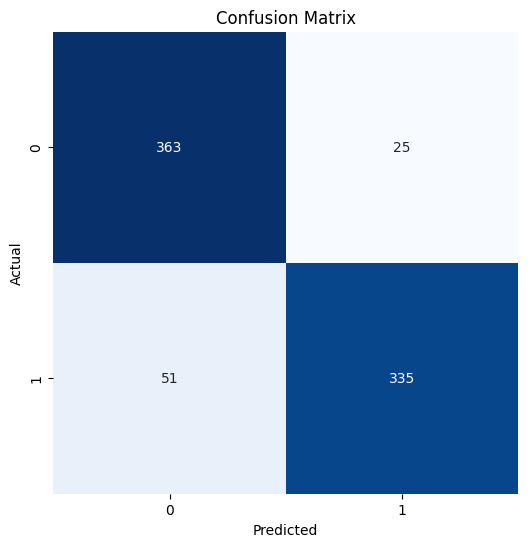

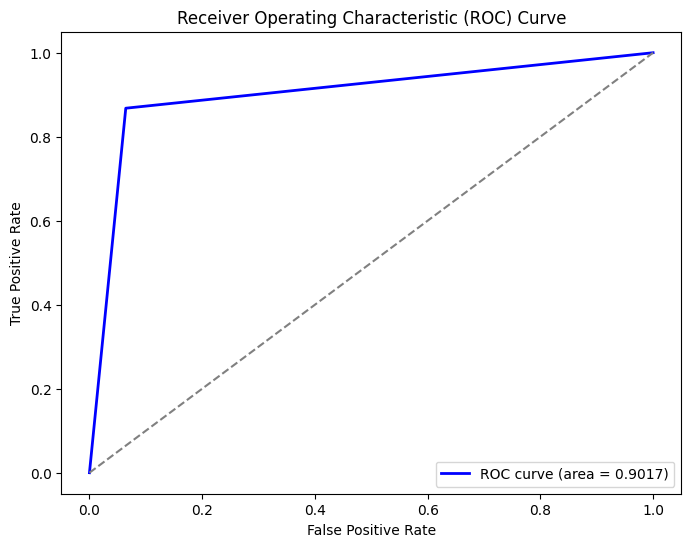


Hyperparameters Used:
  Hyperparameter                     Value
0  Learning Rate                    0.0001
1     Batch Size                        32
2      Optimizer                      Adam
3         Epochs                        10
4          Model  ViT (Vision Transformer)
5     Image Size                (224, 224)


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import ViTForImageClassification

# Load the best model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
model.load_state_dict(torch.load('/content/vit_best_model.pth'))
model.to(device)

# Hyperparameters for table
hyperparameters = {
    'Learning Rate': 1e-4,
    'Batch Size': 32,
    'Optimizer': 'Adam',
    'Epochs': 10,
    'Model': 'ViT (Vision Transformer)',
    'Image Size': (224, 224),
}

# --- Model Evaluation on Test Set ---
model.eval()  # Set model to evaluation mode
test_preds = []
test_labels = []
test_loss = 0.0
correct_test = 0
total_test = 0

# Run evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()

        # Predictions
        _, predicted = torch.max(outputs.logits, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

# Calculate test accuracy
test_acc = accuracy_score(test_labels, test_preds)
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# --- Hyperparameter Table ---
hyperparameters_df = pd.DataFrame(hyperparameters.items(), columns=['Hyperparameter', 'Value'])
print("\nHyperparameters Used:")
print(hyperparameters_df)




---



# **Bar Graphs**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Heatmaps/bargraphs.zip'
extract_path = '/content/bargraphs'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/bargraphs.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ViT's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset setup
data_dir = '/content/bargraphs'  # Path to your data
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Splitting the dataset into 80% training, 10% validation, 10% test
train_size = int(0.8 * len(dataset))
val_test_size = len(dataset) - train_size
val_size = val_test_size // 2
test_size = val_test_size - val_size  # Ensure total matches dataset size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
model.to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Early stopping parameters
patience = 5  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
patience_counter = 0

# Training loop with validation and early stopping
for epoch in range(10):  # Run for 10 epochs
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate validation accuracy
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/10, Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model if it has improved
        torch.save(model.state_dict(), '/content/vit_best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
            break

# Load the best model after training (for evaluation)
model.load_state_dict(torch.load('/content/vit_best_model.pth'))
model.to(device)

# Test accuracy
model.eval()  # Set model to evaluation mode
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Save final model if desired
torch.save(model.state_dict(), '/content/vit_model_final.pth')
print("Model saved!")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5312, Validation Loss: 0.3935, Validation Accuracy: 0.8331
Epoch 2/10, Train Loss: 0.3799, Validation Loss: 0.3721, Validation Accuracy: 0.8370
Epoch 3/10, Train Loss: 0.3390, Validation Loss: 0.4534, Validation Accuracy: 0.8150
Epoch 4/10, Train Loss: 0.3100, Validation Loss: 0.3379, Validation Accuracy: 0.8577
Epoch 5/10, Train Loss: 0.2784, Validation Loss: 0.4191, Validation Accuracy: 0.8486
Epoch 6/10, Train Loss: 0.2610, Validation Loss: 0.4496, Validation Accuracy: 0.8098
Epoch 7/10, Train Loss: 0.2379, Validation Loss: 0.3429, Validation Accuracy: 0.8603
Epoch 8/10, Train Loss: 0.2017, Validation Loss: 0.3593, Validation Accuracy: 0.8448
Epoch 9/10, Train Loss: 0.1581, Validation Loss: 0.4329, Validation Accuracy: 0.8396
Early stopping at epoch 9 due to no improvement in validation loss.


<ipython-input-8-e9a8a9ec0a1d>:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/vit_best_model.pth'))


Test Accuracy: 0.8708
Model saved!


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-b211ef187cc2>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Test Accuracy: 0.8708, Test Loss: 0.3192

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       394
           1       0.90      0.83      0.86       380

    accuracy                           0.87       774
   macro avg       0.87      0.87      0.87       774
weighted avg       0.87      0.87      0.87       774



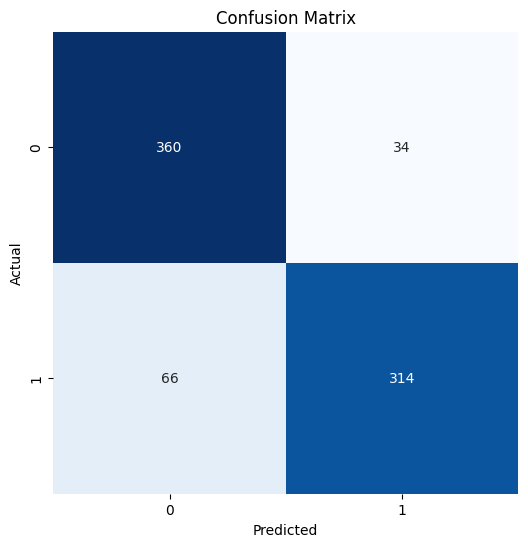

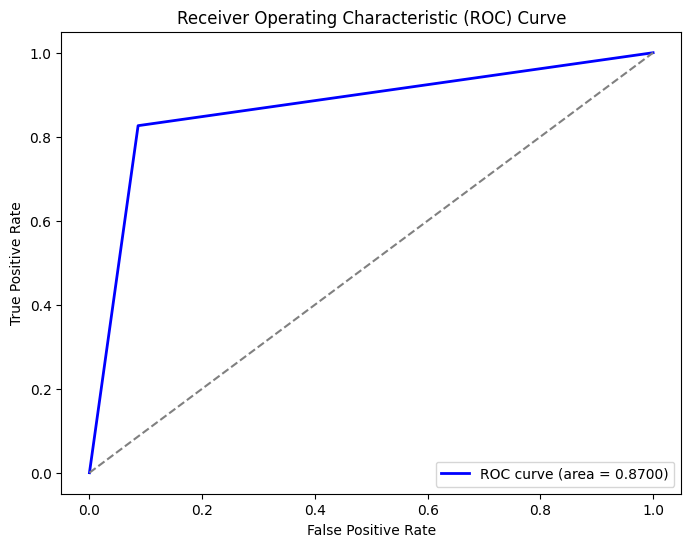


Hyperparameters Used:
  Hyperparameter                     Value
0  Learning Rate                    0.0001
1     Batch Size                        32
2      Optimizer                      Adam
3         Epochs                        10
4          Model  ViT (Vision Transformer)
5     Image Size                (224, 224)


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import ViTForImageClassification

# Load the best model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
model.load_state_dict(torch.load('/content/vit_best_model.pth'))
model.to(device)

# Hyperparameters for table
hyperparameters = {
    'Learning Rate': 1e-4,
    'Batch Size': 32,
    'Optimizer': 'Adam',
    'Epochs': 10,
    'Model': 'ViT (Vision Transformer)',
    'Image Size': (224, 224),
}

# --- Model Evaluation on Test Set ---
model.eval()  # Set model to evaluation mode
test_preds = []
test_labels = []
test_loss = 0.0
correct_test = 0
total_test = 0

# Run evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()

        # Predictions
        _, predicted = torch.max(outputs.logits, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

# Calculate test accuracy
test_acc = accuracy_score(test_labels, test_preds)
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# --- Hyperparameter Table ---
hyperparameters_df = pd.DataFrame(hyperparameters.items(), columns=['Hyperparameter', 'Value'])
print("\nHyperparameters Used:")
print(hyperparameters_df)

# **Heatmaps**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Heatmaps/heatmaps.zip'
extract_path = '/content/heatmaps'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/heatmaps.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ViT's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset setup
data_dir = '/content/heatmaps'  # Path to your data
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Splitting the dataset into 80% training, 10% validation, 10% test
train_size = int(0.8 * len(dataset))
val_test_size = len(dataset) - train_size
val_size = val_test_size // 2
test_size = val_test_size - val_size  # Ensure total matches dataset size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
model.to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Early stopping parameters
patience = 5  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
patience_counter = 0

# Training loop with validation and early stopping
for epoch in range(10):  # Run for 10 epochs
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate validation accuracy
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/10, Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model if it has improved
        torch.save(model.state_dict(), '/content/vit_best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
            break

# Load the best model after training (for evaluation)
model.load_state_dict(torch.load('/content/vit_best_model.pth'))
model.to(device)

# Test accuracy
model.eval()  # Set model to evaluation mode
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Save final model if desired
torch.save(model.state_dict(), '/content/vit_model_final.pth')
print("Model saved!")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4533, Validation Loss: 0.4172, Validation Accuracy: 0.8305
Epoch 2/10, Train Loss: 0.3351, Validation Loss: 0.3276, Validation Accuracy: 0.8745
Epoch 3/10, Train Loss: 0.3082, Validation Loss: 0.3079, Validation Accuracy: 0.8771
Epoch 4/10, Train Loss: 0.2727, Validation Loss: 0.2832, Validation Accuracy: 0.8849
Epoch 5/10, Train Loss: 0.2525, Validation Loss: 0.2625, Validation Accuracy: 0.8965
Epoch 6/10, Train Loss: 0.2439, Validation Loss: 0.2713, Validation Accuracy: 0.8991
Epoch 7/10, Train Loss: 0.2345, Validation Loss: 0.2614, Validation Accuracy: 0.9030
Epoch 8/10, Train Loss: 0.2115, Validation Loss: 0.2390, Validation Accuracy: 0.9133
Epoch 9/10, Train Loss: 0.2067, Validation Loss: 0.2610, Validation Accuracy: 0.8926
Epoch 10/10, Train Loss: 0.1974, Validation Loss: 0.2419, Validation Accuracy: 0.9004


<ipython-input-11-3d33f257c673>:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/vit_best_model.pth'))


Test Accuracy: 0.9134
Model saved!


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-b211ef187cc2>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Test Accuracy: 0.9134, Test Loss: 0.2092

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       392
           1       0.96      0.86      0.91       382

    accuracy                           0.91       774
   macro avg       0.92      0.91      0.91       774
weighted avg       0.92      0.91      0.91       774



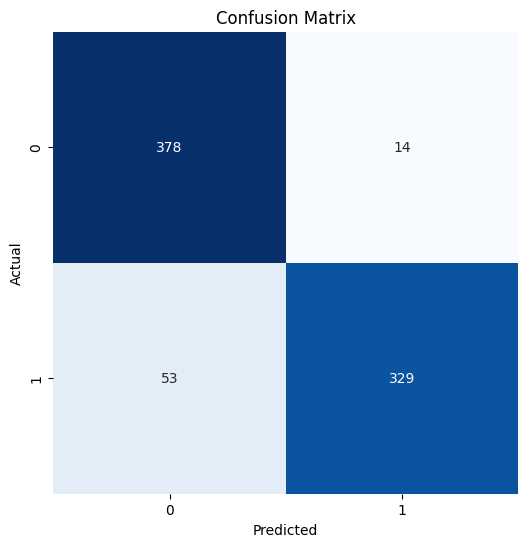

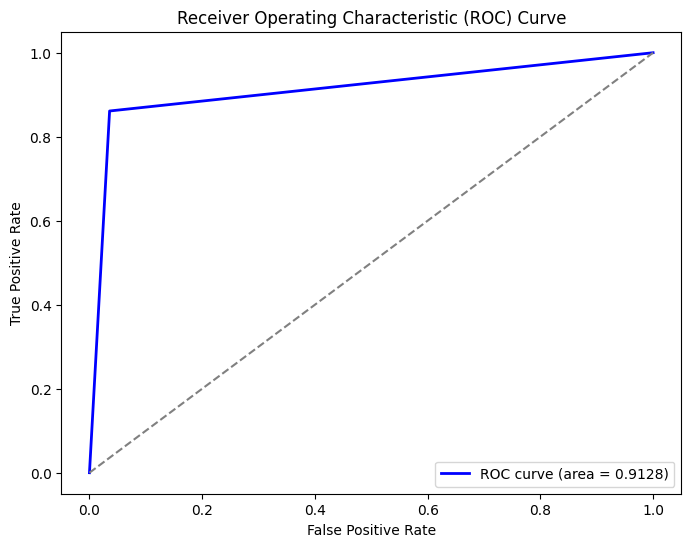


Hyperparameters Used:
  Hyperparameter                     Value
0  Learning Rate                    0.0001
1     Batch Size                        32
2      Optimizer                      Adam
3         Epochs                        10
4          Model  ViT (Vision Transformer)
5     Image Size                (224, 224)


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import ViTForImageClassification

# Load the best model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
model.load_state_dict(torch.load('/content/vit_best_model.pth'))
model.to(device)

# Hyperparameters for table
hyperparameters = {
    'Learning Rate': 1e-4,
    'Batch Size': 32,
    'Optimizer': 'Adam',
    'Epochs': 10,
    'Model': 'ViT (Vision Transformer)',
    'Image Size': (224, 224),
}

# --- Model Evaluation on Test Set ---
model.eval()  # Set model to evaluation mode
test_preds = []
test_labels = []
test_loss = 0.0
correct_test = 0
total_test = 0

# Run evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()

        # Predictions
        _, predicted = torch.max(outputs.logits, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

# Calculate test accuracy
test_acc = accuracy_score(test_labels, test_preds)
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# --- Hyperparameter Table ---
hyperparameters_df = pd.DataFrame(hyperparameters.items(), columns=['Hyperparameter', 'Value'])
print("\nHyperparameters Used:")
print(hyperparameters_df)